# Credits

**a)** All Jared

**b)** Mostly Maria, everyone brainstormed priors in class.

**c)** All Maria

In [32]:
import numpy as np
import pandas as pd

import arviz as az

import bebi103

# Import Altair for high level plotting
import altair as alt
import altair_catplot as altcat
# Pevent bulky altair plots
alt.data_transformers.enable('json')


import bokeh.io
import bokeh.plotting
bokeh.io.output_notebook()

Loading BokehJS ...

## Problem 8.2: Microtubule catastrophe, 40 pts

_Note: This problem is best done after the lecture November 22._

In this problem, we use data from [Gardner, Zanic, et al., Depolymerizing kinesins Kip3 and MCAK shape cellular microtubule architecture by differential control of catastrophe, *Cell*, **147**, 1092-1103, 2011](https://doi.org/10.1016/j.cell.2011.10.037). The authors investigated the dynamics of microtubule catastrophe, the switching of a microtubule from a growing to a shrinking state.  In particular, they were interested in the time between the start of growth of a microtubule and the catastrophe event. They monitored microtubules in a single-molecule [TIRF assay](https://en.wikipedia.org/wiki/Total_internal_reflection_fluorescence_microscope) by using tubulin (the monomer that comprises a microtubule) that was labeled with a fluorescent marker. As a control to make sure that fluorescent labels and exposure to laser light did not affect the microtubule dynamics, they performed a similar experiment using differential interference contrast (DIC) microscopy. They measured the time until catastrophe with labeled and unlabeled tubulin. We will carefully analyze the data and make some conclusions about the processes underlying microtubule catastrophe.

In the file `gardner_mt_catastrophe_only_tubulin.csv` (which you can download [here](../data/gardner_mt_catastrophe_only_tubulin.csv)), we have observed catastrophe times of microtubules with different concentrations of tubulin. To start with, we will consider the experiment run with a tubulin concentration of 12 µM. So, our data set consists of a set of measurements of the amount of time to catastrophe. We will consider three models for microtubule catastrophe.

- Model 1: The time to catastrophe is Exponentially distributed.
- Model 2: The time to catastrophe is Gamma distributed.
- Model 3: The time to catastrophe is Weibull distributed.

Note that these descriptions are for the likelihood; we have not specified priors.


**a)  Describe the three models in words. Give physical descriptions of the meanings of their parameters. Describe how these models are related to each other. Tutorial 3c will be useful.** 


- Model 1: The time to catastrophe is Exponentially distributed.

This suggests that the occurance of catastrophe is a Poisson process, so it is a "rare event" that requires multiple subprocesses to lead it it. The parameter for the process, if it is exponential, $\beta$, represents the characteristic rate of catastrophe, that is how often catastrophe happens in a certain amount of time. It can also be parametrized as $\tau=1/\beta$, the characteristic catastrophe time, which fits what we are given in our data. The Exponential distribution is a special case of the Gamma distribution where $\alpha = 1$ and a special case of the Weibull distribution where $\alpha = 1$ and $\sigma=1/\beta$



- Model 2: The time to catastrophe is Gamma distributed.

This suggests that the occurance of catastrophe represents a specific number of occurances of a Poisson process, that is a discrete number of steps that occur at the same rate must occur for catastrophe to occur. There are two parameters for this distribution, $\alpha$ and $\beta$, where $\alpha$ is the number of arrivals (or "steps") required to trigger catastrophe, and $\beta$ is the rate of the arrivals. Thus, the characteristic catastrophe time is given by $\alpha/\beta$. 


- Model 3: The time to catastrophe is Weibull distributed.

This suggests that the likelihood of catastrophe is dependent on the amount of time it has been since the last catastrophe, so the longer it has been since the last catastrophe, the more likely it is that catastrophe will occur. There are two parameters for this distribution, $\alpha$ which defines how the probability changes over time, and $\sigma$ which is the characteristic catastrophe time.

**b) Perform parameter estimates for the respective models and make model comparisons. Comment on what this means with respect to our understanding of how microtubule catastrophe works.**

We first load in our data and come up with our priors for the parameters of the three distributions. We don't have much prior knowledge so we will keep them simple (normal distribution).

**Exponential(beta)**

tau ~ normal(400, 100)

beta = 1/tau

We guess that the castastrophe times will be in the hundreds.

**Gamma($\alpha$, $\beta$)**

alpha ~ normal(10, 3)

We assume that it will take around 10 arrivals to trigger catastrophe.

tau ~ normal(150, 50)

beta = 1/tau


**Weibull($\alpha$, $\sigma$)**

$\alpha$ ~ normal(1, 0.1)

We think that the rate of catastrophe is not dependent on the time elapsed from the last event, so we center our distribution aroud 1 without much variation.

$\sigma$ ~ normal(10, 3)


In [2]:
df = pd.read_csv('../data/gardner_mt_catastrophe_only_tubulin.csv', comment = "#")

In [3]:
# Check out the data we are working with
df.head()

,12 uM,7 uM,9 uM,10 uM,14 uM
0,25.000,35.0,25.0,50.0,60.0
1,40.000,45.0,40.0,60.0,75.0
2,40.000,50.0,40.0,60.0,75.0
3,45.429,50.0,45.0,75.0,85.0
4,50.000,55.0,50.0,75.0,115.0


In [4]:
prior_sm1 = bebi103.stan.StanModel(file='./8.2_prior_pred_12_m1.stan')
prior_sm2 = bebi103.stan.StanModel(file='./8.2_prior_pred_12_m2.stan')
prior_sm3 = bebi103.stan.StanModel(file='./8.2_prior_pred_12_m3.stan')

Using cached StanModel.
Using cached StanModel.
Using cached StanModel.


In [5]:
# Store input parameters in a dictionary so stan can access them
data = dict(N=692)

# Generate samples
samples_gen1 = prior_sm1.sampling(data=data,
                          algorithm='Fixed_param',
                          warmup=0,
                          chains=1,
                          iter=1000)
samples_gen2 = prior_sm2.sampling(data=data,
                          algorithm='Fixed_param',
                          warmup=0,
                          chains=1,
                          iter=1000)
samples_gen3 = prior_sm3.sampling(data=data,
                          algorithm='Fixed_param',
                          warmup=0,
                          chains=1,
                          iter=1000)

# Store samples in a dataframe
df_gen1 = bebi103.stan.to_dataframe(samples_gen1, diagnostics=False)
df_gen2 = bebi103.stan.to_dataframe(samples_gen2, diagnostics=False)
df_gen3 = bebi103.stan.to_dataframe(samples_gen3, diagnostics=False)

# Let's look at one of the dataframes to make sure they look ok
df_gen3.head()

,chain,chain_idx,warmup,time[1],time[2],time[3],time[4],time[5],time[6],time[7],...,time[686],time[687],time[688],time[689],time[690],time[691],time[692],alpha,sigma,lp__
0,1,1,0,161.924021,352.996287,165.022184,66.534654,76.082489,10.199717,312.488896,...,566.787962,790.352216,660.337791,35.020921,95.584586,43.678872,107.105056,1.111181,263.425533,0.0
1,1,2,0,794.933317,274.512398,200.254908,493.053157,160.820417,1092.645605,182.157237,...,121.016150,302.527699,54.129282,265.740458,293.975851,203.616577,455.549264,1.238508,332.892583,0.0
2,1,3,0,8.450511,219.126550,6.672607,235.458058,380.878001,190.628235,352.146155,...,269.193308,23.430470,403.323979,588.559168,218.964384,143.713016,258.520033,1.056656,249.515821,0.0
3,1,4,0,101.383154,512.603494,297.511670,203.572635,291.546030,147.336544,142.831215,...,802.554297,150.417123,200.649278,383.114774,106.368434,204.766609,63.805082,1.081341,419.617026,0.0
4,1,5,0,111.328407,244.465145,883.738008,787.226558,197.197026,132.116564,13.293659,...,1530.536577,855.054928,109.239736,281.058748,764.086881,862.608871,233.012466,1.021863,560.364616,0.0


Yay! It looks ok so we can move on to plotting our prior predictive checks.

In [6]:
p = bebi103.viz.predictive_ecdf(samples_gen1, "time",
                                x_axis_label = "intercatastrophe time (s)")
p.x_range = bokeh.models.Range1d(-10, 6000)
bokeh.io.show(p)

In [7]:
p = bebi103.viz.predictive_ecdf(samples_gen2, "time",
                                x_axis_label = "intercatastrophe time (s)")
p.x_range = bokeh.models.Range1d(-10, 3000)
bokeh.io.show(p)

In [8]:
p = bebi103.viz.predictive_ecdf(samples_gen3, "time",
                                x_axis_label = "intercatastrophe time (s)")
p.x_range = bokeh.models.Range1d(-10, 1000)
bokeh.io.show(p)

Our priors look reasonable, since times are centered in the hundreds, so now we can move on to creating our mcmc models and sampling.

In [9]:
sm1 = bebi103.stan.StanModel(file='./8.2_mcmc_12_m1.stan')
sm2 = bebi103.stan.StanModel(file='./8.2_mcmc_12_m2.stan')
sm3 = bebi103.stan.StanModel(file='./8.2_mcmc_12_m3.stan')

Using cached StanModel.
Using cached StanModel.
Using cached StanModel.


In [10]:
data = dict(N=len(df),
           time=df['12 uM'].values.astype(float))

In [11]:
samples1 = sm1.sampling(data=data)
samples2 = sm2.sampling(data=data)
samples3 = sm3.sampling(data=data)

/Users/jaredlivingston/anaconda3/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


In [12]:
df_mcmc1 = bebi103.stan.to_dataframe(samples1, diagnostics=False, inc_warmup=False)
df_mcmc2 = bebi103.stan.to_dataframe(samples2, diagnostics=False, inc_warmup=False)
df_mcmc3 = bebi103.stan.to_dataframe(samples3, diagnostics=False, inc_warmup=False)

We now plot the post predictive checks to do model comparison.

In [13]:
bokeh.io.show(bebi103.viz.predictive_ecdf(samples1, 
                                          percentiles=[99, 70, 50, 30],
                                          name='time_ppc', 
                                          data=df['12 uM'].values,
                                          diff=True,
                                          data_line=False))

We can see there is a systematic issue with using the exponential distribution becuase the two inflection points will always be in the wrong place.

In [14]:
bokeh.io.show(bebi103.viz.predictive_ecdf(samples2, 
                                          percentiles=[99, 70, 50, 30],
                                          name='time_ppc', 
                                          data=df['12 uM'].values,
                                          diff=True,
                                          data_line=False))

The gamma distribution looks a lot more promising! Most of our values fall into that innermost confidence interval.

In [15]:
bokeh.io.show(bebi103.viz.predictive_ecdf(samples3, 
                                          percentiles=[99, 70, 50, 30],
                                          name='time_ppc', 
                                          data=df['12 uM'].values,
                                          diff=True,
                                          data_line=False))

Ooof the weibull distribution model is also not great (better than exponential though). Only a few of our datapoints will fall in that 99% confidence interval, so the curve isn't a very good match.

To confirm quantitatively, we compute the loo given the log likelihood and use the bebi103 compare function to calculate the loo and the weights.

In [16]:
bebi103.stan.compare({'exponential': samples1, 'gamma': samples2, 'weibull': samples3},
                     log_likelihood='log_like', ic='loo')

,loo,ploo,dloo,weight,se,dse,warning
gamma,9278.47,2.1712,0,0.989508,45.3345,0,0
weibull,9321.3,2.10819,42.8308,4.25596e-12,43.0787,9.3661,0
exponential,9608.54,0.352812,330.075,0.010492,31.8458,28.2278,0


We can see that gamma (Model 2) is the best distribution to fit our data because the weight is much higher (0.95 vs 10^-2 and 10^-13). Based on the visual analysis of the post predictive checks above,  this makes a lot of sense! 

**c) Using whichever model you favor based on your work in part (b), obtain parameter estimates for the other tubulin concentrations. Given that microtubules polymerize faster with higher tubulin concentrations, is there anything you can say about the occurrence of catastrophe by looking at the values of the parameters versus tubulin concentration?**


We picked the gamma distribution model so we will now sample out of it for all 5 concentrations in the dataframe.

In [17]:
data12 = dict(N=len(df),
           time=df['12 uM'].values.astype(float))
data7 = dict(N=len(df['7 uM'].dropna()),
           time=df['7 uM'].dropna().values.astype(float))
data9 = dict(N=len(df['9 uM'].dropna()),
           time=df['9 uM'].dropna().values.astype(float))
data10 = dict(N=len(df['10 uM'].dropna()),
           time=df['10 uM'].dropna().values.astype(float))
data14 = dict(N=len(df['14 uM'].dropna()),
           time=df['14 uM'].dropna().values.astype(float))

In [18]:
samples12 = sm2.sampling(data=data12)
samples7 = sm2.sampling(data=data7)
samples9 = sm2.sampling(data=data9)
samples10 = sm2.sampling(data=data10)
samples14 = sm2.sampling(data=data14)

We now preform post predictive checks and can conlcude that the gamma model is resoanble for all 5 concentrations.

In [19]:
bokeh.io.show(bebi103.viz.predictive_ecdf(samples12, 
                                          percentiles=[99, 70, 50, 30],
                                          name='time_ppc', 
                                          data=df['12 uM'].values,
                                          diff=True,
                                          data_line=False,
                                          title = "12 uM",
                                          x_axis_label = "intercatastrophe time (s)"))

In [20]:
bokeh.io.show(bebi103.viz.predictive_ecdf(samples7, 
                                          percentiles=[99, 70, 50, 30],
                                          name='time_ppc', 
                                          data=df['7 uM'].dropna().values,
                                          diff=True,
                                          data_line=False,
                                          title = "7 uM",
                                          x_axis_label = "intercatastrophe time (s)"))

In [21]:
bokeh.io.show(bebi103.viz.predictive_ecdf(samples9, 
                                          percentiles=[99, 70, 50, 30],
                                          name='time_ppc', 
                                          data=df['9 uM'].dropna().values,
                                          diff=True,
                                          data_line=False,
                                          title = "9 uM",
                                          x_axis_label = "intercatastrophe time (s)"))

In [22]:
bokeh.io.show(bebi103.viz.predictive_ecdf(samples10, 
                                          percentiles=[99, 70, 50, 30],
                                          name='time_ppc', 
                                          data=df['10 uM'].dropna().values,
                                          diff=True,
                                          data_line=False,
                                          title = "10 uM",
                                          x_axis_label = "intercatastrophe time (s)"))

In [23]:
bokeh.io.show(bebi103.viz.predictive_ecdf(samples14, 
                                          percentiles=[99, 70, 50, 30],
                                          name='time_ppc', 
                                          data=df['14 uM'].dropna().values,
                                          diff=True,
                                          data_line=False,
                                          title = "14 uM",
                                          x_axis_label = "intercatastrophe time (s)"))

Now we want to examine the occurrence of catastrophe by looking at the values of the parameters versus tubulin concentration?

There are two parameters for this distribution,  𝛼  and  𝛽 , where  𝛼  is the number of arrivals (or "steps") required to trigger catastrophe, and  𝛽  is the rate of the arrivals. Thus, the characteristic catastrophe time is given by  𝛼/𝛽 .

We first need to put our sampled values in a dataframe so we can look at the parameters

In [50]:
df_mcmc7 = bebi103.stan.to_dataframe(samples7, diagnostics=False, inc_warmup=False)
df_mcmc9 = bebi103.stan.to_dataframe(samples9, diagnostics=False, inc_warmup=False)
df_mcmc10 = bebi103.stan.to_dataframe(samples10, diagnostics=False, inc_warmup=False)
df_mcmc12 = bebi103.stan.to_dataframe(samples12, diagnostics=False, inc_warmup=False)
df_mcmc14 = bebi103.stan.to_dataframe(samples14, diagnostics=False, inc_warmup=False)

Let's make a column labeling each dataframe for ease of plotting:

In [51]:
df_mcmc7["Concentration"] = 7
df_mcmc9["Concentration"] = 9
df_mcmc10["Concentration"] = 10
df_mcmc12["Concentration"] = 12
df_mcmc14["Concentration"] = 14

Now let's take a look at the 𝛼 values for each concentration. This will give us an idea of the amount of steps required to trigger catastrophe:

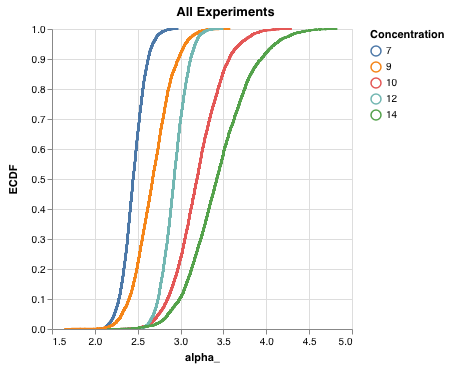

In [54]:
# First let's make a helper plotting function
def make_ecdf(dataframe, data, title):
    c = altcat.catplot(data=dataframe,
               mark='line',
               encoding=dict(x=alt.X(data,
                                     scale=alt.Scale(
                                           clamp=True)),
                            color = alt.Color("Concentration")),
               transform='ecdf'
              ).properties(height=300,
                           width=300,
                           title = title)
    return c

# Now let's plot
(make_ecdf(df_mcmc7, "alpha_:Q", "All Experiments") 
+ make_ecdf(df_mcmc9, "alpha_:Q", "All Experiments") 
+ make_ecdf(df_mcmc10, "alpha_:Q", "All Experiments")
+ make_ecdf(df_mcmc12, "alpha_:Q", "All Experiments") 
+ make_ecdf(df_mcmc14, "alpha_:Q", "All Experiments"))



In general 𝛼 appears to increase with increasing concentration, although this is not true for concentration 12. This indicates that with higher concentration, it takes more steps to trigger catastrophe.

Now let's take a look at $\beta$

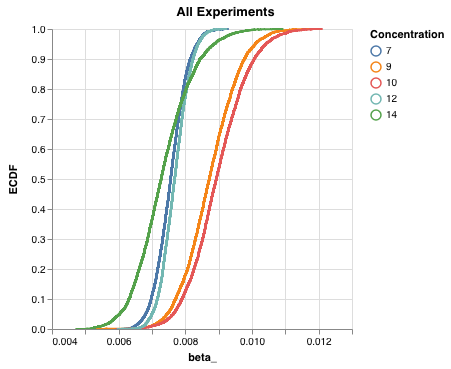

In [55]:
(make_ecdf(df_mcmc7, "beta_:Q", "All Experiments") 
+ make_ecdf(df_mcmc9, "beta_:Q", "All Experiments") 
+ make_ecdf(df_mcmc10, "beta_:Q", "All Experiments")
+ make_ecdf(df_mcmc12, "beta_:Q", "All Experiments") 
+ make_ecdf(df_mcmc14, "beta_:Q", "All Experiments"))

We can also calculate the average characteristic catastrophe time (given by  𝛼/𝛽 ) for each concentration.

In [56]:
df_mcmc7["alpha/beta"] = df_mcmc7["alpha_"] / df_mcmc7["beta_"]
df_mcmc9["alpha/beta"] = df_mcmc9["alpha_"] / df_mcmc9["beta_"]
df_mcmc10["alpha/beta"] = df_mcmc10["alpha_"] / df_mcmc10["beta_"]
df_mcmc12["alpha/beta"] = df_mcmc12["alpha_"] / df_mcmc12["beta_"]
df_mcmc14["alpha/beta"] = df_mcmc14["alpha_"] / df_mcmc14["beta_"]

Let's take a look.

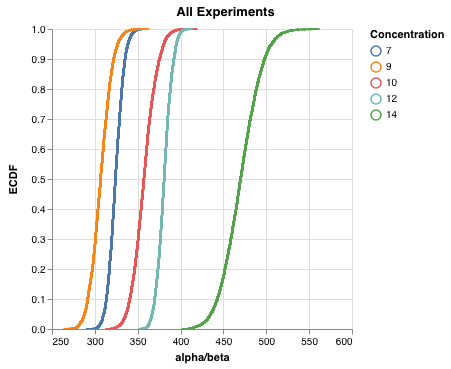

In [57]:
(make_ecdf(df_mcmc7, "alpha/beta:Q", "All Experiments") 
+ make_ecdf(df_mcmc9, "alpha/beta:Q", "All Experiments") 
+ make_ecdf(df_mcmc10, "alpha/beta:Q", "All Experiments")
+ make_ecdf(df_mcmc12, "alpha/beta:Q", "All Experiments") 
+ make_ecdf(df_mcmc14, "alpha/beta:Q", "All Experiments"))

As concentration increases, the characteristic catastrophe time seems to generally increase (the 9uM data breaks this trend). This makes sense given that microtubules polymerize faster with higher tubulin concentrations.

Finally, I will print out all the model / prior predictive check code for your viewing pleasure.

In [27]:
print("-------------MODEL CHECK 1-------------")
print(prior_sm1.model_code)
print("-------------MODEL CHECK 2-------------")
print(prior_sm2.model_code)
print("-------------MODEL CHECK 3-------------")
print(prior_sm3.model_code)

-------------MODEL CHECK 1-------------
data{
    // Model 1
    int N;
}

generated quantities{
    // Parameters
    real time[N];
    real beta_;
       
    beta_ = 1.0 / normal_rng(400, 100);
    
    // Data
    for (i in 1:N) {
        time[i] = exponential_rng(beta_);
    }
}

-------------MODEL CHECK 2-------------
data{
    // Model 2
    int N;
}

generated quantities{
    // Parameters
    real time[N];
    real beta_;
    real alpha;
       
    alpha = normal_rng(10, 3);
    beta_ = 1 / normal_rng(150, 50);
    
    // Data
    for (i in 1:N) {
        time[i] = gamma_rng(alpha, beta_);
    }
}
-------------MODEL CHECK 3-------------
data{
    // Model 3
    int N;
}

generated quantities{
    // Parameters
    real time[N];
    real alpha;
    real sigma;

    // Likelihood  
    alpha = normal_rng(1, 0.1);
    sigma = normal_rng(400, 100);
    
    // Data
    for (i in 1:N) {
        time[i] = weibull_rng(alpha, sigma);
    }
}


In [28]:
print("-------------MODEL 1-------------")
print(sm1.model_code)
print("-------------MODEL 2-------------")
print(sm2.model_code)
print("-------------MODEL 3-------------")
print(sm3.model_code)

-------------MODEL 1-------------
data{
    // Model 1
    int N;
    real time[N];
}

parameters{
    real tao;
}

transformed parameters{
    real beta_;
    beta_ = 1.0 / tao;
}

model{
    // Priors
    tao ~ normal(400, 100);

    // Likelihood
    time ~ exponential(beta_);
}

generated quantities{
    // Parameters
    real log_like[N];
    real time_ppc[N];
    
    // Draw from likelihood for post check
    for (i in 1:N) {
        time_ppc[i] = exponential_rng(beta_);
    }
    
    // Pointwise likelihood   
    for (i in 1:N) {
        log_like[i] = exponential_lpdf(time[i] | beta_);
    }
}
-------------MODEL 2-------------
data{
    // Model 2
    int N;
    real time[N];
}

parameters{
    real alpha_;
    real tao;
}

transformed parameters{
    real beta_;
    beta_ = 1.0 / tao;
}

model{
    // Priors
    alpha_ ~ normal(10, 3);
    tao ~ normal(150, 50);

    // Likelihood
    time ~ gamma(alpha_, beta_);
}

generated quantities{
    // Parameters
    real log_like[N